In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis

In [52]:
raw_data = pd.read_csv('RC_2019_10.csv', low_memory=False)  

### Adding aircraft information based on Tail Number

In [53]:
aircraft_data = pd.read_csv('MASTER.txt', low_memory=False)  
aircraft_data['N-NUMBER'] = aircraft_data['N-NUMBER'].str.strip()
aircraft_data['N-NUMBER'] = 'N' + aircraft_data['N-NUMBER'].astype(str)
aircraft_data = aircraft_data.rename(columns={"N-NUMBER": "Tail_Number", "MFR MDL CODE": "aircraft_code"})

In [54]:
raw_data = raw_data.merge(aircraft_data[['Tail_Number', 'aircraft_code']], on='Tail_Number', how='left')

### Data for Analysis

In [55]:
data = raw_data[['OriginAirportSeqID', 'DestAirportSeqID', 'FlightDate', 'Tail_Number',
                 'CRSDepTime', 'CRSArrTime', 'Reporting_Airline', 'Flight_Number_Reporting_Airline', 
                 'aircraft_code', 'CRSElapsedTime', 'Distance', 'ArrivalDelayGroups', 'Cancelled']]

### Preprocessing columns which have flight time information

In [56]:
data = data.assign(carrier_flightnum = lambda x: x.Reporting_Airline + x.Flight_Number_Reporting_Airline.astype(str))
data = data.assign(CRSDepHr = lambda x: x.CRSDepTime/100)
data = data.assign(CRSDepMin = lambda x: x.CRSDepTime%100)
data = data.assign(CRSArrHr = lambda x: x.CRSArrTime/100)
data = data.assign(CRSArrMin = lambda x: x.CRSArrTime%100)
data[['CRSDepHr', 'CRSDepMin', 'CRSArrHr', 'CRSArrMin']] = data[['CRSDepHr', 'CRSDepMin', 'CRSArrHr', 'CRSArrMin']].astype(int)

### Adding labels for later analysis/classification

In [57]:
def delay_group_label_fxn(x):
    if x['ArrivalDelayGroups']>0 and x['ArrivalDelayGroups']<=1: return 'less_than_15_min'
    elif x['ArrivalDelayGroups']>1 and x['ArrivalDelayGroups']<=2: return 'between_15_to_30_min'
    elif x['ArrivalDelayGroups']>2 and x['ArrivalDelayGroups']<=4: return 'between_30_to_60_min'
    elif x['ArrivalDelayGroups']>4 and x['ArrivalDelayGroups']<=8: return 'between_60_to_120_min'
    elif x['ArrivalDelayGroups']>8 or x['Cancelled']==1: return 'greater_than_120_min'
    else: return 'no_delay'
def delay_label_fxn(x):
    if x['ArrivalDelayGroups']>1 or x['Cancelled']==1: return 0 #0 for "delay"
    else: return 1 #1 for "no delay"
data['delay_group_label'] = data.apply(delay_group_label_fxn, axis=1)
data['delay_label'] = data.apply(delay_label_fxn, axis=1)

### Checking for null values in dataset

In [58]:
data.isnull().sum(axis = 0)

OriginAirportSeqID                     0
DestAirportSeqID                       0
FlightDate                             0
Tail_Number                          394
CRSDepTime                             0
CRSArrTime                             0
Reporting_Airline                      0
Flight_Number_Reporting_Airline        0
aircraft_code                      10088
CRSElapsedTime                         0
Distance                               0
ArrivalDelayGroups                  6377
Cancelled                              0
carrier_flightnum                      0
CRSDepHr                               0
CRSDepMin                              0
CRSArrHr                               0
CRSArrMin                              0
delay_group_label                      0
delay_label                            0
dtype: int64

In [59]:
display(data.sample(n=5, random_state=42))

,OriginAirportSeqID,DestAirportSeqID,FlightDate,Tail_Number,CRSDepTime,CRSArrTime,Reporting_Airline,Flight_Number_Reporting_Airline,aircraft_code,CRSElapsedTime,Distance,ArrivalDelayGroups,Cancelled,carrier_flightnum,CRSDepHr,CRSDepMin,CRSArrHr,CRSArrMin,delay_group_label,delay_label
627486,1410702,1129806,2019-10-27,N205UW,1523,1945,AA,981,1384973,142.0,868.0,4.0,0.0,AA981,15,23,19,45,between_30_to_60_min,0
239328,1226603,1349505,2019-10-30,N857RW,2150,2259,YX,3440,3260406,69.0,305.0,1.0,0.0,YX3440,21,50,22,59,less_than_15_min,1
251047,1502403,1169706,2019-10-24,N531NK,1626,1922,NK,212,3940015,176.0,1107.0,-1.0,0.0,NK212,16,26,19,22,no_delay,1
238777,1161802,1412202,2019-10-28,N730YX,1805,1939,YX,3533,3260415,94.0,319.0,-1.0,0.0,YX3533,18,5,19,39,no_delay,1
581159,1410702,1457002,2019-10-05,N843NN,2011,2159,AA,1095,13844CB,108.0,601.0,0.0,0.0,AA1095,20,11,21,59,no_delay,1


In [60]:
print(data.shape)

(636014, 20)


### Defining features and target variables for analysis/classification

In [61]:
feats = ['OriginAirportSeqID', 'DestAirportSeqID', 'CRSDepHr', 'CRSDepMin', 
        'CRSArrHr', 'CRSArrMin', 'Tail_Number', 'aircraft_code', 'Reporting_Airline', 
        'carrier_flightnum', 'CRSElapsedTime', 'Distance']
#0, 1, 6, 7, 8, 9

In [62]:
target_vars = ['ArrivalDelayGroups', 'Cancelled', 'delay_group_label', 'delay_label']

In [63]:
data[feats+target_vars].dtypes

OriginAirportSeqID      int64
DestAirportSeqID        int64
CRSDepHr                int64
CRSDepMin               int64
CRSArrHr                int64
CRSArrMin               int64
Tail_Number            object
aircraft_code          object
Reporting_Airline      object
carrier_flightnum      object
CRSElapsedTime        float64
Distance              float64
ArrivalDelayGroups    float64
Cancelled             float64
delay_group_label      object
delay_label             int64
dtype: object

In [64]:
numeric_features = ['CRSDepHr', 'CRSDepMin', 'CRSArrHr', 'CRSArrMin', 'CRSElapsedTime', 'Distance']
categorical_features = ['OriginAirportSeqID', 'DestAirportSeqID', 'Tail_Number', 'aircraft_code', 'carrier_flightnum', 'Reporting_Airline']


In [65]:
for feat in categorical_features:
    data[feat] = data[feat].astype('category')

### Checking for duplicate data

In [66]:
dup = data[feats+target_vars].duplicated()
print('Number of duplicate rows : ', len(dup[dup]))
data.drop_duplicates(subset=feats+target_vars, inplace=True)

Number of duplicate rows :  36751


## Data Summary

In [67]:
display(data.sample(n=5, random_state=42))
data.shape

,OriginAirportSeqID,DestAirportSeqID,FlightDate,Tail_Number,CRSDepTime,CRSArrTime,Reporting_Airline,Flight_Number_Reporting_Airline,aircraft_code,CRSElapsedTime,Distance,ArrivalDelayGroups,Cancelled,carrier_flightnum,CRSDepHr,CRSDepMin,CRSArrHr,CRSArrMin,delay_group_label,delay_label
366265,1069302,1039707,2019-10-03,N849DN,1611,1820,DL,2599,138488K,69.0,214.0,-1.0,0.0,DL2599,16,11,18,20,no_delay,1
116057,1405702,1483106,2019-10-18,N7742B,1820,2000,WN,2160,1384511,100.0,569.0,-1.0,0.0,WN2160,18,20,20,0,no_delay,1
143067,1042302,1014005,2019-10-20,N269WN,1315,1405,WN,4656,1384404,110.0,619.0,2.0,0.0,WN4656,13,15,14,5,between_15_to_30_min,0
455178,1393007,1530402,2019-10-29,N37255,801,1144,UA,2326,13844BZ,163.0,1011.0,5.0,0.0,UA2326,8,1,11,44,between_60_to_120_min,0
386641,1288903,1143302,2019-10-22,N341DN,1247,1939,DL,414,3940005,232.0,1749.0,0.0,0.0,DL414,12,47,19,39,no_delay,1


(599263, 20)

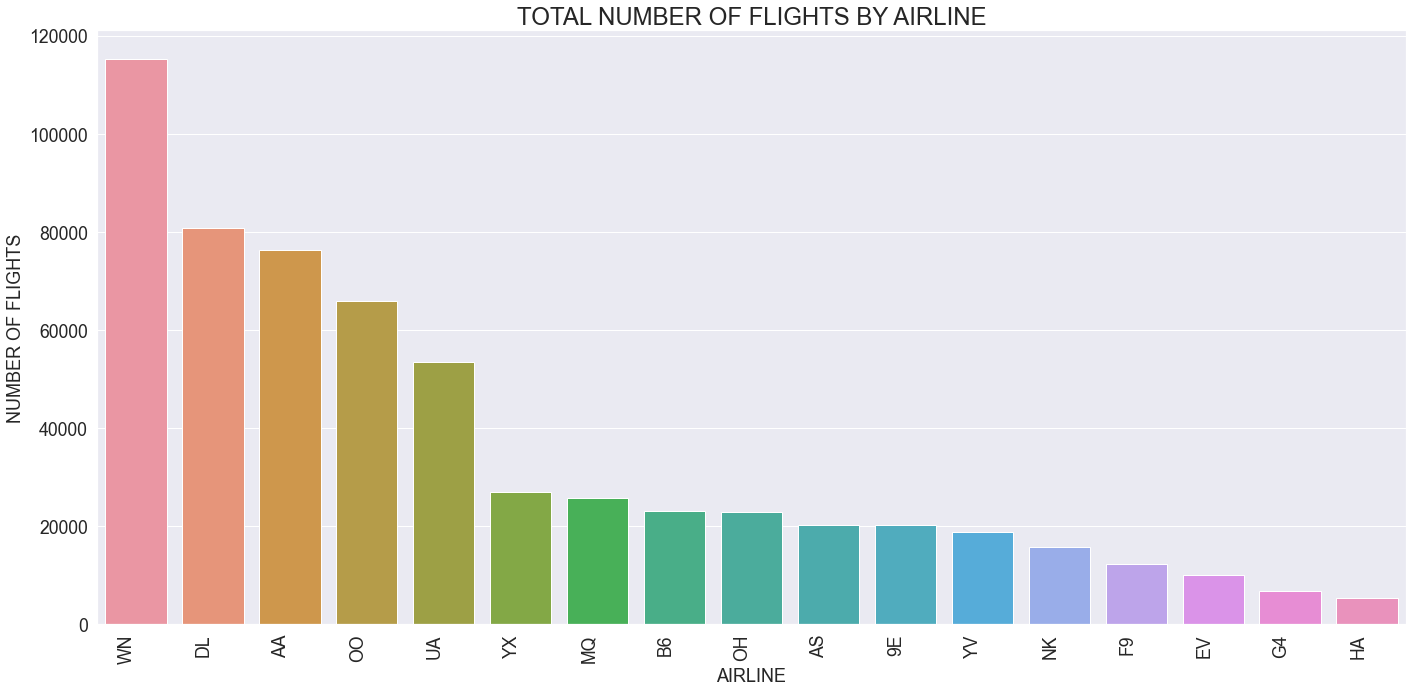

In [68]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.6)
axis = sns.countplot(x=data['Reporting_Airline'], data=data, order=data['Reporting_Airline'].value_counts().index)
axis.set_xticklabels(axis.get_xticklabels(), rotation=90, ha='right')
plt.title('TOTAL NUMBER OF FLIGHTS BY AIRLINE', fontsize=24)
plt.xlabel('AIRLINE', fontsize=18)
plt.ylabel('NUMBER OF FLIGHTS', fontsize=18)
plt.tight_layout()
plt.show()

In [69]:
top_airlines = ['WN', 'DL', 'AA', 'OO', 'UA']

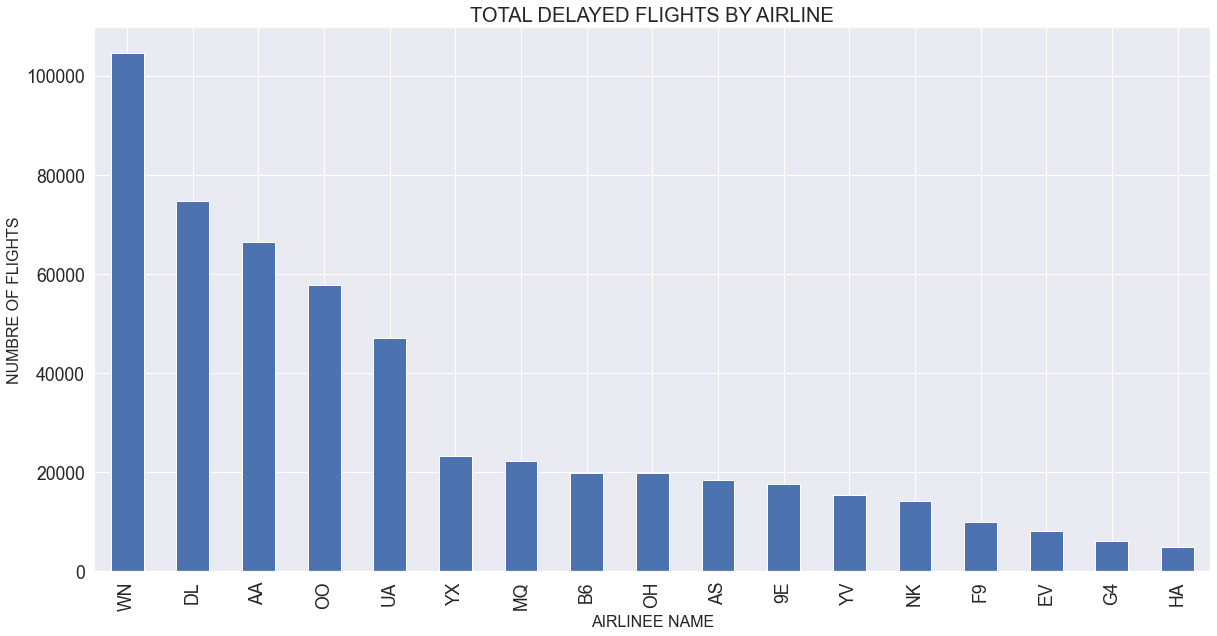

In [70]:
plt.figure(figsize=(20, 10))
data.groupby('Reporting_Airline').delay_label.sum().sort_values(ascending=False).plot.bar()
plt.title('TOTAL DELAYED FLIGHTS BY AIRLINE', fontsize=20)
plt.xlabel('AIRLINEE NAME', fontsize=16)
plt.ylabel('NUMBRE OF FLIGHTS', fontsize=16)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.show()

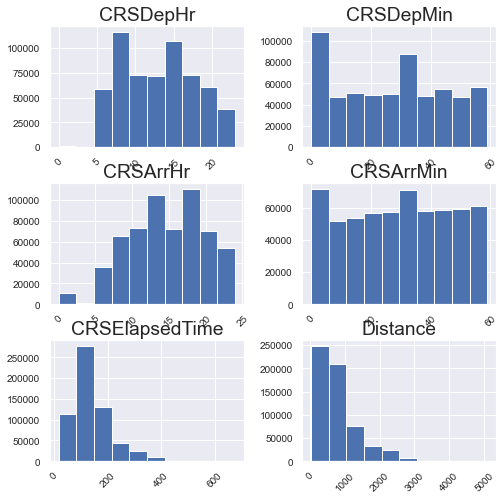

In [71]:
import matplotlib.pyplot as plt

data[numeric_features].hist(figsize=(8,8), xrot=45, bins=10)
plt.show()

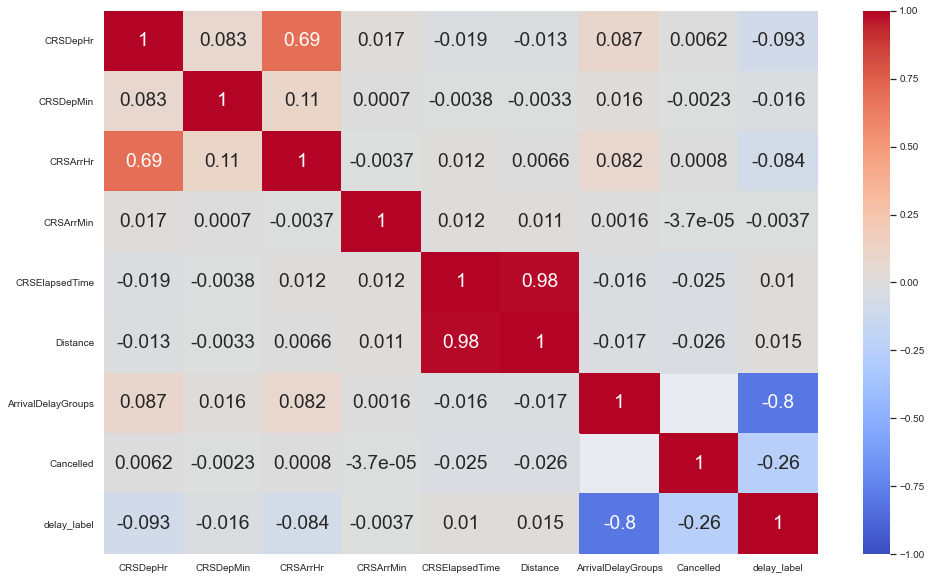

In [72]:
import seaborn as sns
plt.figure(figsize=(16,10))
cor =  data[numeric_features+target_vars].corr()
mask = np.zeros(cor.shape, dtype=bool)
#mask[np.triu_indices(len(mask))] = True
sns.heatmap(cor, vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm', annot = True, mask = mask)
plt.show()

In [73]:
'''
import seaborn as sns
def density_plot_feat(feat, data):
    feat_delay = [x for x in data[data.delay_label.values == 0][feat].values]
    feat_no_delay = [x for x in data[data.delay_label.values == 1][feat].values]
    sns.distplot(feat_delay, bins = 10, label = 'Delay')
    sns.distplot(feat_no_delay, bins = 10, label = 'No Delay')
    plt.legend()
    plt.title('Distribution of ' + str(feat))
    plt.xlabel(feat)
    plt.show()
''';
#for feat in numeric_features:
#    density_plot_feat(feat, data)

### Distribution of data in delayed and cancelled categories

In [74]:
print(data['delay_label'].value_counts(normalize=True))
#print(data['delay_label'].value_counts(normalize=True))

1    0.883734
0    0.116266
Name: delay_label, dtype: float64


In [21]:
print(data['Cancelled'].value_counts())

0.0    594131
1.0      5132
Name: Cancelled, dtype: int64


In [22]:
#print(data['delay_group_label'].value_counts())

## Predicting if a flight will be delayed or not

### Dividing data into training and testing sets

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[feats], data.delay_label, test_size=0.33,
                                                    random_state=42, stratify=data.delay_label)
print("Train Data - ", X_train.shape)
print(y_train.value_counts())

Train Data -  (401506, 12)
1    354824
0     46682
Name: delay_label, dtype: int64


### Preprocessing Data Pipeline

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support, accuracy_score, classification_report

In [25]:
data_preprocessor = ColumnTransformer(transformers = [
    ('categorical_transformer', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

### Naive Bayes 

In [26]:
from sklearn.naive_bayes import MultinomialNB
nb = Pipeline([('data_preprocessor', data_preprocessor),
               ('data_imputer', SimpleImputer(strategy='mean')),
               ('data_scaling', MaxAbsScaler()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print('accuracy: ' , accuracy_score(y_pred_nb, y_test))
precision, recall, f1_score, support = precision_recall_fscore_support(y_pred_nb, y_test, 
                                        labels=np.unique(y_pred_nb), average="macro") 
print('average precision: ', precision)
print('average recall: ', recall)
print('average f1_score: ', f1_score)
print(classification_report(y_test, y_pred_nb))

accuracy:  0.8502101063426326
average precision:  0.5521741397350346
average recall:  0.5806203116290777
average f1_score:  0.5600531784567266
              precision    recall  f1-score   support

           0       0.27      0.16      0.20     22992
           1       0.90      0.94      0.92    174765

    accuracy                           0.85    197757
   macro avg       0.58      0.55      0.56    197757
weighted avg       0.82      0.85      0.83    197757



### Logistic Regression

In [27]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

logreg_pipe = Pipeline([('data_preprocessor', data_preprocessor),
               ('data_imputer', SimpleImputer(strategy='mean')),
               ('data_scaling', MaxAbsScaler()),
               ('clf', LogisticRegression(max_iter=1000, random_state=42)),
              ])
logreg_param_grid = {
    'clf__C'           : [0.1, 1, 10, 100],
    'clf__class_weight': ['balanced']
    #'clf__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }

logreg = GridSearchCV(logreg_pipe, logreg_param_grid, n_jobs=-1, cv=kf)

logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print('accuracy: ' , accuracy_score(y_pred_logreg, y_test))
precision, recall, f1_score, support = precision_recall_fscore_support(y_pred_logreg, y_test, average="macro", labels=np.unique(y_pred_logreg)) 
print('average precision: ', precision)
print('average recall: ', recall)
print('average f1_score: ', f1_score)
print(classification_report(y_test, y_pred_logreg)) #labels=np.unique(y_pred)
print(logreg.best_params_)

accuracy:  0.6578730462132819
average precision:  0.6208416239923018
average recall:  0.553954569027651
average f1_score:  0.5278784261659923
              precision    recall  f1-score   support

           0       0.19      0.57      0.28     22992
           1       0.92      0.67      0.78    174765

    accuracy                           0.66    197757
   macro avg       0.55      0.62      0.53    197757
weighted avg       0.84      0.66      0.72    197757

{'clf__C': 1, 'clf__class_weight': 'balanced'}


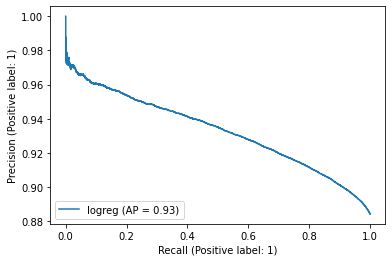

In [28]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(logreg, X_test, y_test, name='logreg')

### Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
rfc = Pipeline([('data_preprocessor', data_preprocessor),
               ('data_imputer', SimpleImputer(strategy='mean')),
               ('data_scaling', MaxAbsScaler()),
               ('clf', RandomForestClassifier(max_depth = 10, n_estimators = 200, random_state=42))
])

rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
print('accuracy: ' , accuracy_score(y_pred_rfc, y_test))
precision, recall, f1_score, support = precision_recall_fscore_support(y_pred_rfc, y_test, average="macro", labels=np.unique(y_pred_rfc)) 
print('average precision: ', precision)
print('average recall: ', recall)
print('average f1_score: ', f1_score)
print(classification_report(y_test, y_pred_rfc)) #labels=np.unique(y_pred)

accuracy:  0.8837361003656002
average precision:  1.0
average recall:  0.8837361003656002
average f1_score:  0.9382801552659978
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     22992
           1       0.88      1.00      0.94    174765

    accuracy                           0.88    197757
   macro avg       0.44      0.50      0.47    197757
weighted avg       0.78      0.88      0.83    197757



/Library/Python/3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Python/3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Gradient Boosting

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

xgb = Pipeline([('data_preprocessor', data_preprocessor),
               ('data_imputer', SimpleImputer(strategy='mean')),
               ('data_scaling', MaxAbsScaler()),
               ('clf', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42))
            ])

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print('accuracy: ' , accuracy_score(y_pred_xgb, y_test))
precision, recall, f1_score, support = precision_recall_fscore_support(y_pred_xgb, y_test, average="macro", labels=np.unique(y_pred_xgb)) 
print('average precision: ', precision)
print('average recall: ', recall)
print('average f1_score: ', f1_score)
print(classification_report(y_test, y_pred_xgb)) #labels=np.unique(y_pred)


accuracy:  0.8842468281780165
average precision:  0.5030273873738114
average recall:  0.8257772851203974
average f1_score:  0.4755151668301299
              precision    recall  f1-score   support

           0       0.77      0.01      0.01     22992
           1       0.88      1.00      0.94    174765

    accuracy                           0.88    197757
   macro avg       0.83      0.50      0.48    197757
weighted avg       0.87      0.88      0.83    197757



### Adaboost

In [31]:
from sklearn.ensemble import AdaBoostClassifier

ada = Pipeline([('data_preprocessor', data_preprocessor),
               ('data_imputer', SimpleImputer(strategy='mean')),
               ('data_scaling', MaxAbsScaler()),
               ('clf', AdaBoostClassifier(n_estimators=100, random_state=42))
            ])

ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
print('accuracy: ' , accuracy_score(y_pred_ada, y_test))
precision, recall, f1_score, support = precision_recall_fscore_support(y_pred_ada, y_test, average="macro", labels=np.unique(y_pred_ada)) 
print('average precision: ', precision)
print('average recall: ', recall)
print('average f1_score: ', f1_score)
print(classification_report(y_test, y_pred_ada)) #labels=np.unique(y_pred)



accuracy:  0.8843327922652549
average precision:  0.5029249384365656
average recall:  0.8812713790377111
average f1_score:  0.47520403323311
              precision    recall  f1-score   support

           0       0.88      0.01      0.01     22992
           1       0.88      1.00      0.94    174765

    accuracy                           0.88    197757
   macro avg       0.88      0.50      0.48    197757
weighted avg       0.88      0.88      0.83    197757



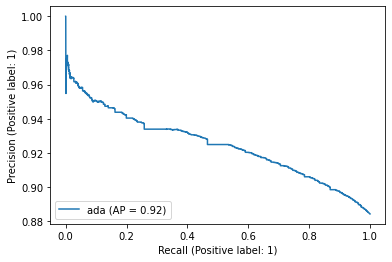

In [32]:
disp = plot_precision_recall_curve(ada, X_test, y_test, name='ada')

### Stacking

In [33]:
from sklearn.ensemble import StackingClassifier

estimators = [('logreg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)),
             ('ada', AdaBoostClassifier(n_estimators=100, random_state=42))]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
                         
stk = Pipeline([('data_preprocessor', data_preprocessor),
               ('data_imputer', SimpleImputer(strategy='mean')),
               ('data_scaling', MaxAbsScaler()),
               ('clf', clf)
            ])

stk.fit(X_train, y_train)
y_pred_stk = stk.predict(X_test)
print('accuracy: ' , accuracy_score(y_pred_stk, y_test))
precision, recall, f1_score, support = precision_recall_fscore_support(y_pred_stk, y_test, average="macro", labels=np.unique(y_pred_stk)) 
print('average precision: ', precision)
print('average recall: ', recall)
print('average f1_score: ', f1_score)
print(classification_report(y_test, y_pred_stk)) #labels=np.unique(y_pred)
                         

accuracy:  0.884383359375395
average precision:  0.5027835768963118
average recall:  0.9421542384973864
average f1_score:  0.4748376635655063
              precision    recall  f1-score   support

           0       1.00      0.01      0.01     22992
           1       0.88      1.00      0.94    174765

    accuracy                           0.88    197757
   macro avg       0.94      0.50      0.47    197757
weighted avg       0.90      0.88      0.83    197757



### Lightgbm

In [34]:
from lightgbm import LGBMClassifier

lgbm = Pipeline([('data_preprocessor', data_preprocessor),
               ('data_imputer', SimpleImputer(strategy='mean')),
               ('data_scaling', MaxAbsScaler()),
               ('clf', LGBMClassifier(n_jobs=-1))
            ])

lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
print('accuracy: ' , accuracy_score(y_pred_lgbm, y_test))
precision, recall, f1_score, support = precision_recall_fscore_support(y_pred_lgbm, y_test, average="macro", labels=np.unique(y_pred_lgbm)) 
print('average precision: ', precision)
print('average recall: ', recall)
print('average f1_score: ', f1_score)
print(classification_report(y_test, y_pred_lgbm)) #labels=np.unique(y_pred)


accuracy:  0.884373245953367
average precision:  0.5028911691853188
average recall:  0.9139963073738843
average f1_score:  0.4750898320878202
              precision    recall  f1-score   support

           0       0.94      0.01      0.01     22992
           1       0.88      1.00      0.94    174765

    accuracy                           0.88    197757
   macro avg       0.91      0.50      0.48    197757
weighted avg       0.89      0.88      0.83    197757



## Using LIME to explain predictions

In [35]:
from sklearn.preprocessing import LabelEncoder

print(categorical_features)
label_encoder = LabelEncoder()
data['OriginAirportSeqID_num'] = label_encoder.fit_transform(data['OriginAirportSeqID'])
data['DestAirportSeqID_num'] = label_encoder.fit_transform(data['DestAirportSeqID'])
data['Tail_Number_num'] = label_encoder.fit_transform(data['Tail_Number'])
data['aircraft_code_num'] = label_encoder.fit_transform(data['aircraft_code'])
data['carrier_flightnum_num'] = label_encoder.fit_transform(data['carrier_flightnum'])
data['Reporting_Airline_num'] = label_encoder.fit_transform(data['Reporting_Airline'])
categorical_features_transformed = ['OriginAirportSeqID_num', 'DestAirportSeqID_num', 'Tail_Number_num', 
                                    'aircraft_code_num', 'carrier_flightnum_num', 'Reporting_Airline_num']
#numeric_features

['OriginAirportSeqID', 'DestAirportSeqID', 'Tail_Number', 'aircraft_code', 'carrier_flightnum', 'Reporting_Airline']


In [36]:
X_train_trans, X_test_trans, y_train, y_test = train_test_split(data[numeric_features+categorical_features_transformed], 
                                                    data.delay_label, test_size=0.33,
                                                    random_state=42, stratify=data.delay_label)


In [37]:
logreg_lime = LogisticRegression(max_iter=1000, random_state=42).fit(X_train_trans, y_train)


In [38]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train_trans, 
                                                   feature_names=data[numeric_features+categorical_features_transformed].columns.tolist(), 
                                                   class_names=[0,1], 
                                                   discretize_continuous=False)

In [39]:
i = np.random.randint(0, X_test_trans.shape[0])
#i = 0
exp = explainer.explain_instance(X_test_trans.iloc[i], logreg_lime.predict_proba, num_features=5, top_labels=1)
print("actual class: ", y_test.iloc[i])
exp.show_in_notebook(show_table=True, show_all=False)

actual class:  1


## Resampling and Training

In [40]:
from imblearn.under_sampling import RandomUnderSampler 
from collections import Counter

In [41]:
rus = RandomUnderSampler(sampling_strategy='majority')
X_res, y_res = rus.fit_sample(data[feats], data.delay_label)
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.33, random_state=42, stratify=y_res)
print('Resampled dataset shape {}'.format(Counter(y_res)))


Resampled dataset shape Counter({0: 69674, 1: 69674})


In [42]:
nb.fit(X_train_res, y_train_res)
y_pred_nb_res = nb.predict(X_test_res)
print('accuracy: ' , accuracy_score(y_pred_nb_res, y_test_res))
precision, recall, f1_score, support = precision_recall_fscore_support(y_pred_nb_res, y_test_res, 
                                        labels=np.unique(y_pred_nb_res), average="macro") 
print('average precision: ', precision)
print('average recall: ', recall)
print('average f1_score: ', f1_score)
print(classification_report(y_test_res, y_pred_nb_res))

accuracy:  0.611960421876699
average precision:  0.6119600358083022
average recall:  0.6121014037308821
average f1_score:  0.6118378968336594
              precision    recall  f1-score   support

           0       0.61      0.63      0.62     22993
           1       0.62      0.59      0.60     22992

    accuracy                           0.61     45985
   macro avg       0.61      0.61      0.61     45985
weighted avg       0.61      0.61      0.61     45985



### SVM

In [48]:
from sklearn.svm import SVC

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

svm_pipe = Pipeline([('data_preprocessor', data_preprocessor),
               ('data_imputer', SimpleImputer(strategy='mean')),
               ('data_scaling', MaxAbsScaler()),
               ('clf', SVC(max_iter=1000, random_state=42, probability=True)),
              ])

svm_param_grid = {
    'clf__gamma'       : ['auto'],
    'clf__C'           : [1],
    'clf__kernel'      : ['linear'],
    'clf__class_weight': ['balanced'],
    'clf__tol': [0.19]
    }

svm = GridSearchCV(svm_pipe, svm_param_grid, n_jobs=-1, cv=kf)

svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print('accuracy: ' , accuracy_score(y_pred_svm, y_test))
precision, recall, f1_score, support = precision_recall_fscore_support(y_pred_svm, y_test, average="macro", labels=np.unique(y_pred_svm)) 
print('average precision: ', precision)
print('average recall: ', recall)
print('average f1_score: ', f1_score)
print(classification_report(y_test, y_pred_svm)) #labels=np.unique(y_pred)
print(svm.best_params_)

/Library/Python/3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


accuracy:  0.11628412647845589
average precision:  0.5000114439390038
average recall:  0.5581331256668672
average f1_score:  0.1041792668871099
              precision    recall  f1-score   support

           0       0.12      1.00      0.21     22992
           1       1.00      0.00      0.00    174765

    accuracy                           0.12    197757
   macro avg       0.56      0.50      0.10    197757
weighted avg       0.90      0.12      0.02    197757

{'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__gamma': 'auto', 'clf__kernel': 'linear', 'clf__tol': 0.19}


In [75]:
from sklearn.neural_network import MLPClassifier

In [81]:
mlp = Pipeline([('data_preprocessor', data_preprocessor),
               ('data_imputer', SimpleImputer(strategy='mean')),
               ('data_scaling', MaxAbsScaler()),
               ('clf', MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6, 6), random_state=1, max_iter=10000))
            ])

mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
print('accuracy: ' , accuracy_score(y_pred_mlp, y_test))
precision, recall, f1_score, support = precision_recall_fscore_support(y_pred_mlp, y_test, average="macro", labels=np.unique(y_pred_mlp)) 
print('average precision: ', precision)
print('average recall: ', recall)
print('average f1_score: ', f1_score)
print(classification_report(y_test, y_pred_mlp)) #labels=np.unique(y_pred)

/Library/Python/3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


accuracy:  0.8582148798778299
average precision:  0.5364387120324478
average recall:  0.5749053763901069
average f1_score:  0.5418749369198578
              precision    recall  f1-score   support

           0       0.26      0.12      0.16     22992
           1       0.89      0.96      0.92    174765

    accuracy                           0.86    197757
   macro avg       0.57      0.54      0.54    197757
weighted avg       0.82      0.86      0.83    197757

